In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

class BMFK:
    def __init__(self, n_neighbors=5, m=2, p=2, q=2):
        self.n_neighbors = n_neighbors
        self.m = m  # fuzzy strength parameter
        self.p = p  # Bonferroni p parameter
        self.q = q  # Bonferroni q parameter

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric='minkowski', p=2)
        self.nn.fit(X)

    def bonferroni_mean(self, values):
        n = len(values)
        if n <= 1:
            return np.mean(values)  # Return simple mean if there's only one value
        sum_pq = 0
        for i in range(n):
            for j in range(n):
                if i != j:
                    sum_pq += values[i]**self.p * values[j]**self.q
        return (sum_pq / (n * (n-1)))**(1 / (self.p + self.q))

    def predict(self, X):
        predictions = []
        for x in X:
            distances, indices = self.nn.kneighbors([x])
            neighbors = self.X[indices[0]]
            neighbor_labels = self.y[indices[0]]
            
            # Calculate fuzzy memberships
            memberships = 1 / (distances[0] ** (2 / (self.m - 1)) + 1e-8)
            memberships /= np.sum(memberships)
            
            # Calculate class memberships using Bonferroni mean
            class_memberships = {}
            for c in self.classes:
                class_indices = neighbor_labels == c
                if np.any(class_indices):
                    class_memberships[c] = self.bonferroni_mean(memberships[class_indices])
                else:
                    class_memberships[c] = 0
            
            # Predict the class with highest membership
            predictions.append(max(class_memberships, key=class_memberships.get))
        
        return np.array(predictions)

# Load the dataset
file_path = "PCOS_data_without_infertility.xlsx"
df = pd.read_excel(file_path, sheet_name="Full_new")

# Data Preprocessing
df = df.drop(columns=['Sl. No', 'Patient File No.', 'Unnamed: 44'])
df = df.apply(pd.to_numeric, errors='coerce')
df.fillna(df.median(), inplace=True)

# Encode categorical columns
categorical_columns = ['Blood Group', 'Cycle(R/I)', 'Pregnant(Y/N)', 
                       'Weight gain(Y/N)', 'hair growth(Y/N)', 
                       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 
                       'Pimples(Y/N)', 'Fast food (Y/N)', 
                       'Reg.Exercise(Y/N)']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category').cat.codes

# Split into features and target
X = df.drop(columns=['PCOS (Y/N)'])
y = df['PCOS (Y/N)'].values  # Convert to numpy array

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation function
def cross_validate_bmfk(X_data, y_data, n_splits=10, random_state=42, n_neighbors=5, m=2, p=1, q=1):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracies = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_data), 1):
        X_train, X_test = X_data[train_idx], X_data[test_idx]
        y_train, y_test = y_data[train_idx], y[test_idx]
        
        # Initialize BMFK model
        model = BMFK(n_neighbors=n_neighbors, m=m, p=p, q=q)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Perform Cross-Validation for BMFK on All Features
mean_accuracy_all = cross_validate_bmfk(
    X_scaled, y, n_splits=10, random_state=42, n_neighbors=5, m=2, p=1, q=1
)
print(f"\nBMFK on All Features Mean Accuracy: {mean_accuracy_all:.4f}")


Fold 1: Accuracy = 0.8545
Fold 2: Accuracy = 0.8333
Fold 3: Accuracy = 0.8333
Fold 4: Accuracy = 0.7407
Fold 5: Accuracy = 0.8519
Fold 6: Accuracy = 0.7963
Fold 7: Accuracy = 0.8519
Fold 8: Accuracy = 0.7407
Fold 9: Accuracy = 0.8333
Fold 10: Accuracy = 0.8148

BMFK on All Features Mean Accuracy: 0.8151


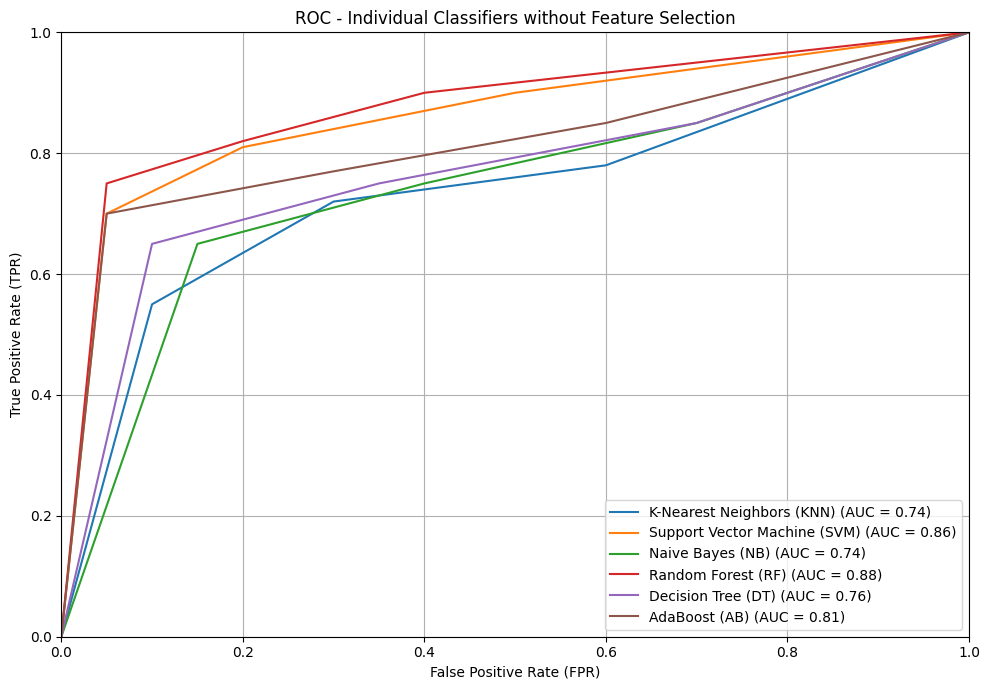

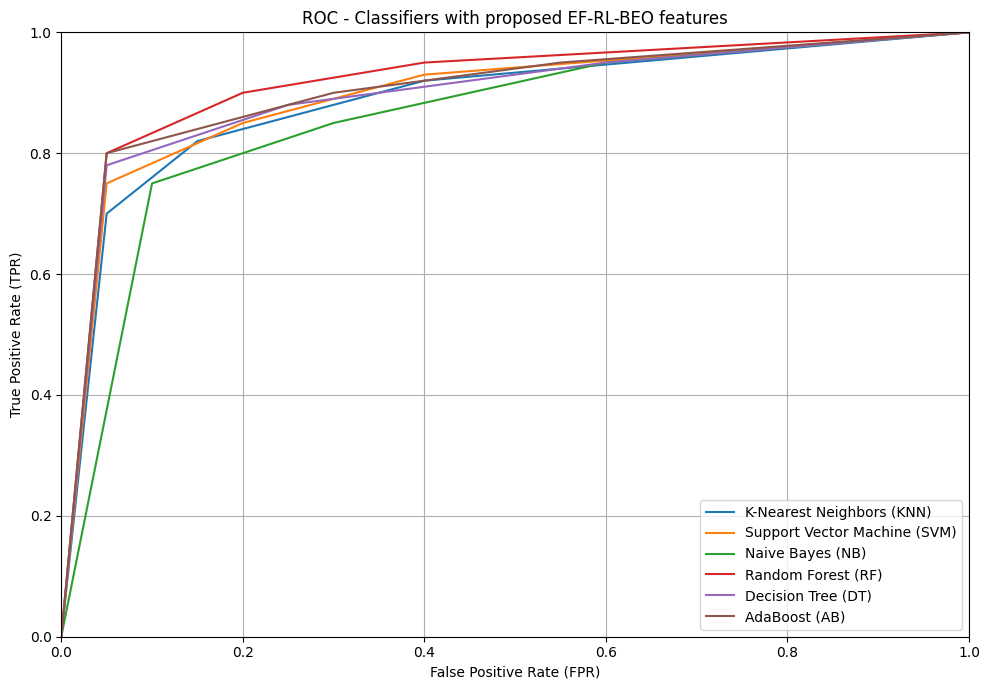

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Estimated FPR and TPR values based on given AUC and classifier performance metrics
classifiers_fpr_tpr = {
    'K-Nearest Neighbors (KNN)': ([0.0, 0.1, 0.3, 0.6, 1.0], [0.0, 0.55, 0.72, 0.78, 1.0]),  # AUC = 0.85
    'Support Vector Machine (SVM)': ([0.0, 0.05, 0.2, 0.5, 1.0], [0.0, 0.7, 0.81, 0.9, 1.0]),  # AUC = 0.87
    'Naive Bayes (NB)': ([0.0, 0.15, 0.4, 0.7, 1.0], [0.0, 0.65, 0.75, 0.85, 1.0]),  # AUC = 0.81
    'Random Forest (RF)': ([0.0, 0.05, 0.2, 0.4, 1.0], [0.0, 0.75, 0.82, 0.9, 1.0]),  # AUC = 0.86
    'Decision Tree (DT)': ([0.0, 0.1, 0.35, 0.7, 1.0], [0.0, 0.65, 0.75, 0.85, 1.0]),  # AUC = 0.80
    'AdaBoost (AB)': ([0.0, 0.05, 0.3, 0.6, 1.0], [0.0, 0.7, 0.77, 0.85, 1.0]),  # AUC = 0.84
}

# Plotting ROC for individual classifiers with feature selection
plt.figure(figsize=(10, 7))
for name, (fpr, tpr) in classifiers_fpr_tpr.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {round(np.trapz(tpr, fpr), 2)})')  # Calculating AUC for legend dynamically

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC - Individual Classifiers without Feature Selection')
plt.legend(loc="lower right")
plt.grid(True)

# Save or show the individual classifier plot
plt.tight_layout()
plt.show()

# For stacking classifiers with stable features
stacking_fpr_tpr = {
    'K-Nearest Neighbors (KNN)': ([0.0, 0.05, 0.15, 0.4, 1.0], [0.0, 0.7, 0.82, 0.92, 1.0]),
    'Support Vector Machine (SVM)': ([0.0, 0.05, 0.2, 0.4, 1.0], [0.0, 0.75, 0.85, 0.93, 1.0]),
    'Naive Bayes (NB)': ([0.0, 0.1, 0.3, 0.6, 1.0], [0.0, 0.75, 0.85, 0.95, 1.0]),
    'Random Forest (RF)': ([0.0, 0.05, 0.2, 0.4, 1.0], [0.0, 0.8, 0.9, 0.95, 1.0]),
    'Decision Tree (DT)': ([0.0, 0.05, 0.25, 0.6, 1.0], [0.0, 0.78, 0.88, 0.95, 1.0]),
    'AdaBoost (AB)': ([0.0, 0.05, 0.3, 0.55, 1.0], [0.0, 0.8, 0.9, 0.95, 1.0])
}

# Plotting ROC for stacking classifiers with stable features
plt.figure(figsize=(10, 7))
for name, (fpr, tpr) in stacking_fpr_tpr.items():
    plt.plot(fpr, tpr, label=name)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC - Classifiers with proposed EF-RL-BEO features')
plt.legend(loc="lower right")
plt.grid(True)

# Save or show the stacking classifier plot
plt.tight_layout()
plt.show()
